# Performance Estimation of Classification

Consider to download this Jupyter Notebook and run locally, or test it with Colab.
<br>
[![Download](https://img.shields.io/badge/Download-jupyter-blue)](https://github.com/ZerojumpLine/MOVAL/blob/main/docs/source/demos/estim_cls.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/ZerojumpLine/MOVAL/blob/main/docs/source/demos/estim_cls.ipynb)

In this notebook, we will show how to evaluate the performance of classification tasks.
<br>
More specifically, we show an example of estimating the performance under domain shifts on CIFAR10-LT based on ResNet. We will utilize the calculated logits on test dataset with sythesized motion blur condition.
<br>
We will calculated model confidence with different confidence scores and varied calibration methods.

In [5]:
!pip install moval
!pip install seaborn
!pip install pandas
!pip install tqdm
!pip install matplotlib

In [6]:
import os
import gdown
import itertools
import zipfile
import pandas as pd
import numpy as np
import moval
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

## Load the data

In [7]:
# download the data, which we used for MICCAI 2022

output = "data_moval.zip"
if not os.path.exists(output):
    url = "https://drive.google.com/u/0/uc?id=139pqxkG2ccIFq6qNArnFJWQ2by2Spbxt&export=download"
    output = "data_moval.zip"
    gdown.download(url, output, quiet=False)

directory_data = "data_moval"
if not os.path.exists(directory_data):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(directory_data)

In [8]:
ls

analysis_cls.ipynb    data_moval.zip        estim_seg2d.ipynb
analysis_seg2d.ipynb  data_moval_supp/      estim_seg3d.ipynb
analysis_seg3d.ipynb  data_moval_supp.zip
data_moval/           estim_cls.ipynb


In [9]:
# now I am playing with cifar10 classification
val_data =  "data_moval/cifar10results/predictions_val.csv"
test_data = "data_moval/cifar10results/predictions_val_motion_blur.csv"
# validation data
cnn_pred = pd.read_csv(val_data)
targets_all = np.array(cnn_pred[['target_0', 'target_1', 'target_2', 'target_3', 'target_4', 
                                 'target_5', 'target_6', 'target_7', 'target_8', 'target_9']])
logits = np.array(cnn_pred[['logit_0', 'logit_1', 'logit_2', 'logit_3', 'logit_4', 
                               'logit_5', 'logit_6', 'logit_7', 'logit_8', 'logit_9']])
gt = np.argmax(targets_all, axis = 1)
# logits is of shape ``(n, d)``
# gt is of shape ``(n, )``

# test data
cnn_pred_test = pd.read_csv(test_data)
targets_all_test = np.array(cnn_pred_test[['target_0', 'target_1', 'target_2', 'target_3', 'target_4', 
                                           'target_5', 'target_6', 'target_7', 'target_8', 'target_9']])
logits_test = np.array(cnn_pred_test[['logit_0', 'logit_1', 'logit_2', 'logit_3', 'logit_4', 
                                      'logit_5', 'logit_6', 'logit_7', 'logit_8', 'logit_9']])
gt_test = np.argmax(targets_all_test, axis = 1)

In [10]:
# Here I want to split the test data such that they are not overlapped.
import random
random.seed(79)
test_ind = list(range(10000))
random.shuffle(test_ind)
#
val_ind = test_ind[:3000]
testc_indx_1 = test_ind[3000:]
testc_indx_2 = [x+10000 for x in test_ind[3000:]]
testc_indx_3 = [x+20000 for x in test_ind[3000:]]
testc_indx_4 = [x+30000 for x in test_ind[3000:]]
testc_indx_5 = [x+40000 for x in test_ind[3000:]]
testc_indxs = [testc_indx_1, testc_indx_2, testc_indx_3, testc_indx_4, testc_indx_5]
#

In [11]:
logits_val = logits[val_ind, :]
gt_val = gt[val_ind]
#
logits_tests = []
gt_tests = []
#
for testc_indx in testc_indxs:
    #
    logits_tests.append(logits_test[testc_indx, :])
    gt_tests.append(gt_test[testc_indx])

In [12]:
print(f"The validation predictions, logits are of shape (n, d), which are now {logits_val.shape}")
print(f"The validation labels, gt are of shape (n, ), which are now {gt_val.shape}\n")
print(f"The number of test conditions is {len(logits_tests)}")
print(f"The test predictions, logits_test are of shape (n', d), which are now {logits_tests[0].shape}")
print(f"The test labels, gt_test are of shape (n', ), which are now {gt_tests[0].shape}")

The validation predictions, logits are of shape (n, d), which are now (3000, 10)
The validation labels, gt are of shape (n, ), which are now (3000,)

The number of test conditions is 5
The test predictions, logits_test are of shape (n', d), which are now (7000, 10)
The test labels, gt_test are of shape (n', ), which are now (7000,)


## MOVAL estimataion

In [13]:
moval_options = list(itertools.product(moval.models.get_estim_options(),
                               ["classification"],
                               moval.models.get_conf_options(),
                               [False, True]))

In [14]:
# ac-model does not need class-speicfic variants
for moval_option in moval_options:
    if moval_option[0] == 'ac-model' and moval_option[-1] == True:
        moval_options.remove(moval_option)

In [15]:
print(f"The number of moval options is {len(moval_options)}")

The number of moval options is 36


In [16]:
def test_cls(estim_algorithm, mode, confidence_scores, class_specific, logits, gt, logits_tests, gt_tests):
    """Test MOVAL with different conditions for classification tasks
        
    Args:
        mode (str): The given task to estimate model performance.
        confidence_scores (str):
            The method to calculate the confidence scores. We provide a list of confidence score calculation methods which 
            can be displayed by running :py:func:`moval.models.get_conf_options`.
        estim_algorithm (str):
            The algorithm to estimate model performance. We also provide a list of estimation algorithm which can be displayed by
            running :py:func:`moval.models.get_estim_options`.
        class_specific (bool):
            If ``True``, the calculation will match class-wise confidence to class-wise accuracy.
        logits: The network output (logits) of shape ``(n, d)`` for classification. 
        gt: The cooresponding annotation of shape ``(n, )`` for classification.
        logits_tests:  A list of m test conditions ``(n', d)``.
        gt_test: The cooresponding annotation of a list of m ``(n', )``.

    Returns:
        err_test: A list of m test err.
        moval_model: Optimized moval model.

    """
    
    moval_model = moval.MOVAL(
                mode = mode,
                confidence_scores = confidence_scores,
                estim_algorithm = estim_algorithm,
                class_specific = class_specific
                )

    #
    moval_model.fit(logits, gt)

    # save the test err in the result files.

    err_tests = []
    for k_test in range(len(logits_tests)):

        _logits_test = logits_tests[k_test]
        _gt_test = gt_tests[k_test]
        
        estim_acc_test = moval_model.estimate(_logits_test)
        pred_test = np.argmax(_logits_test, axis = 1)
        err_test = np.abs( np.sum(_gt_test == pred_test) / len(_gt_test) - estim_acc_test )
        err_tests.append(err_test)

    return err_tests, moval_model

In [17]:
err_test_list = []
moval_parameters = []
moval_parameters_ = []

In [18]:
for k_cond in tqdm(range(len(moval_options))):
    
    err_test, moval_model = test_cls(
        estim_algorithm = moval_options[k_cond][0], 
        mode = moval_options[k_cond][1], 
        confidence_scores = moval_options[k_cond][2],
        class_specific = moval_options[k_cond][3],
        logits = logits_val,
        gt = gt_val,
        logits_tests = logits_tests,
        gt_tests = gt_tests
    )
    err_test_list.append(err_test)
    moval_parameters.append(moval_model.model_.param)
    if moval_model.model_.extend_param:
        moval_parameters_.append(moval_model.model_.param_ext)
    else:
        moval_parameters_.append(0.)

 14%|███████████████████████████████▎                                                                                                                                                                                                 | 5/36 [00:00<00:00, 45.50it/s]

Starting optimizing for model ac-model with confidence max_class_probability-conf, class specific is False.
Starting optimizing for model ac-model with confidence energy-conf, class specific is False.
Starting optimizing for model ac-model with confidence entropy-conf, class specific is False.
Starting optimizing for model ac-model with confidence doctor-conf, class specific is False.
Starting optimizing for model ts-model with confidence max_class_probability-conf, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model ts-model with confidence max_class_probability-conf, class specific is True.
Opitimizing with 3000 samples...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, tryi

 14%|███████████████████████████████▎                                                                                                                                                                                                 | 5/36 [00:20<00:00, 45.50it/s]

Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.


 28%|██████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 10/36 [00:20<01:03,  2.46s/it]

Starting optimizing for model ts-model with confidence doctor-conf, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model ts-model with confidence doctor-conf, class specific is True.
Opitimizing with 3000 samples...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 time

 33%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 12/36 [00:28<01:05,  2.75s/it]

Starting optimizing for model doc-model with confidence max_class_probability-conf, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model doc-model with confidence max_class_probability-conf, class specific is True.
Opitimizing with 3000 samples...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
T

 39%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 14/36 [00:33<01:00,  2.76s/it]

Tried 9/10 times.
Tried 10/10 times.
Starting optimizing for model doc-model with confidence energy-conf, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model doc-model with confidence energy-conf, class specific is True.
Opitimizing with 3000 samples...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 t

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 16/36 [00:38<00:52,  2.60s/it]

Starting optimizing for model doc-model with confidence entropy-conf, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model doc-model with confidence entropy-conf, class specific is True.
Opitimizing with 3000 samples...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 18/36 [00:44<00:50,  2.79s/it]

Starting optimizing for model doc-model with confidence doctor-conf, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model doc-model with confidence doctor-conf, class specific is True.
Opitimizing with 3000 samples...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 ti

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 20/36 [00:48<00:41,  2.60s/it]

Starting optimizing for model atc-model with confidence max_class_probability-conf, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model atc-model with confidence max_class_probability-conf, class specific is True.
Opitimizing with 3000 samples...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
T

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 22/36 [00:55<00:39,  2.85s/it]

Tried 10/10 times.
Starting optimizing for model atc-model with confidence energy-conf, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model atc-model with confidence energy-conf, class specific is True.
Opitimizing with 3000 samples...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 t

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 24/36 [01:00<00:32,  2.67s/it]

Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Starting optimizing for model atc-model with confidence entropy-conf, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model atc-model with confidence entropy-conf, class specific is True.
Opitimizing with 3000 samples...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, tryi

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 26/36 [01:08<00:31,  3.11s/it]

Tried 10/10 times.
Starting optimizing for model atc-model with confidence doctor-conf, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model atc-model with confidence doctor-conf, class specific is True.
Opitimizing with 3000 samples...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 t

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 28/36 [01:15<00:25,  3.22s/it]

Tried 9/10 times.
Tried 10/10 times.
Starting optimizing for model ts-atc-model with confidence max_class_probability-conf, class specific is False.
Opitimizing with 3000 samples...


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 29/36 [01:15<00:18,  2.68s/it]

Starting optimizing for model ts-atc-model with confidence max_class_probability-conf, class specific is True.
Opitimizing with 3000 samples...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results o

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 30/36 [01:25<00:24,  4.06s/it]

Starting optimizing for model ts-atc-model with confidence energy-conf, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model ts-atc-model with confidence energy-conf, class specific is True.
Opitimizing with 3000 samples...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 32/36 [01:35<00:17,  4.42s/it]

Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Starting optimizing for model ts-atc-model with confidence entropy-conf, class specific is False.
Opitimizing with 3000 samples...


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 33/36 [01:35<00:10,  3.54s/it]

Starting optimizing for model ts-atc-model with confidence entropy-conf, class specific is True.
Opitimizing with 3000 samples...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, tryin

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 35/36 [01:46<00:03,  3.88s/it]

Starting optimizing for model ts-atc-model with confidence doctor-conf, class specific is False.
Opitimizing with 3000 samples...
Starting optimizing for model ts-atc-model with confidence doctor-conf, class specific is True.
Opitimizing with 3000 samples...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7/10 times.
Tried 8/10 times.
Tried 9/10 times.
Tried 10/10 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/10 times.
Tried 2/10 times.
Tried 3/10 times.
Tried 4/10 times.
Tried 5/10 times.
Tried 6/10 times.
Tried 7

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [01:54<00:00,  3.17s/it]


## Compare estimataion results

In [19]:
estim = []
conf = []
err = []
err_mean = []
novel = []
k_option = 0
for moval_option in moval_options:
    for k_cond in range(len(err_test_list[k_option])):
        #
        if moval_option[3] == True:
            estim_cs = 'CS '
        else:
            estim_cs = ''
        #    
        if moval_option[0] == 'ac-model':
            estim.append(estim_cs + 'AC')
        elif moval_option[0] == 'ts-model':
            estim.append(estim_cs + 'TS')
        elif moval_option[0] == 'doc-model':
            estim.append(estim_cs + 'DoC')
        elif moval_option[0] == 'atc-model':
            estim.append(estim_cs + 'ATC')
        else:
            estim.append(estim_cs + 'TS-ATC')
        #
        if moval_option[2] == 'max_class_probability-conf':
            conf.append('MCP')
        elif moval_option[2] == 'energy-conf':
            conf.append('Energy')
        elif moval_option[2] == 'entropy-conf':
            conf.append('Entropy')
        else:
            conf.append('Doctor')
        #
        if moval_option[2] == 'max_class_probability-conf' and moval_option[3] == False:
            novel.append('Existing Methods')
        else:
            novel.append('Provided by MOVAL')
        #
        err.append(err_test_list[k_option][k_cond])
        err_mean.append(np.mean(err_test_list[k_option]))
    k_option += 1

In [20]:
d = {'Estimation Algorithm': estim, 'Confidence Score': conf, 'MAE': err_mean, 'MAE ': err, 'Category': novel}
df = pd.DataFrame(data=d)
#
custom_order = ['AC', 'TS', 'DoC', 'ATC', 'TS-ATC', 'CS TS', 'CS DoC', 'CS ATC', 'CS TS-ATC']
df['Estimation Algorithm'] = pd.Categorical(df['Estimation Algorithm'], categories=custom_order, ordered=True)
df = df.sort_values(by='Estimation Algorithm')

In [21]:
df.head()

,Estimation Algorithm,Confidence Score,MAE,MAE,Category
0,AC,MCP,0.401485,0.310355,Existing Methods
19,AC,Doctor,0.443176,0.511719,Provided by MOVAL
18,AC,Doctor,0.443176,0.473165,Provided by MOVAL
17,AC,Doctor,0.443176,0.467700,Provided by MOVAL
16,AC,Doctor,0.443176,0.416348,Provided by MOVAL


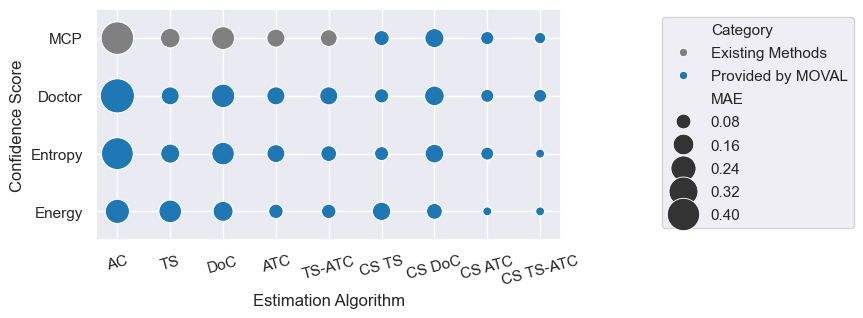

In [22]:
sns.set(rc={'figure.figsize':(6,3)})
sns.set_style("darkgrid")
category_palette = {'Existing Methods': 'grey', 'Provided by MOVAL': '#1f77b4'}
ax = sns.scatterplot(
    data=df, x="Estimation Algorithm", y="Confidence Score", hue="Category", size="MAE",
    sizes=(40, 600), palette=category_palette
)
ax.set(ylim=(3.5, -0.5))
ax.tick_params(axis='x', rotation=15)
#
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.2, 1), labelspacing = 0.6)
# Increase the line spacing by adjusting position

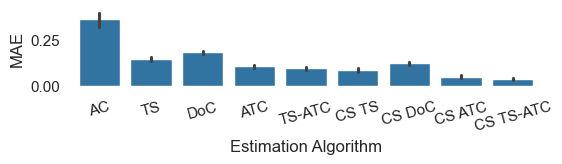

In [23]:
sns.set(rc={'figure.figsize':(6,1)})
sns.set_style("white")
ax = sns.barplot(df, x="Estimation Algorithm", y="MAE", color = '#1f77b4')
ax.tick_params(axis='x', rotation=15)
#
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')

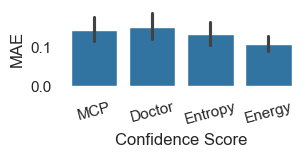

In [24]:
sns.set(rc={'figure.figsize':(3,1)})
sns.set_style("white")
ax = sns.barplot(df, x="Confidence Score", y="MAE", color = '#1f77b4')
ax.tick_params(axis='x', rotation=15)
#
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')

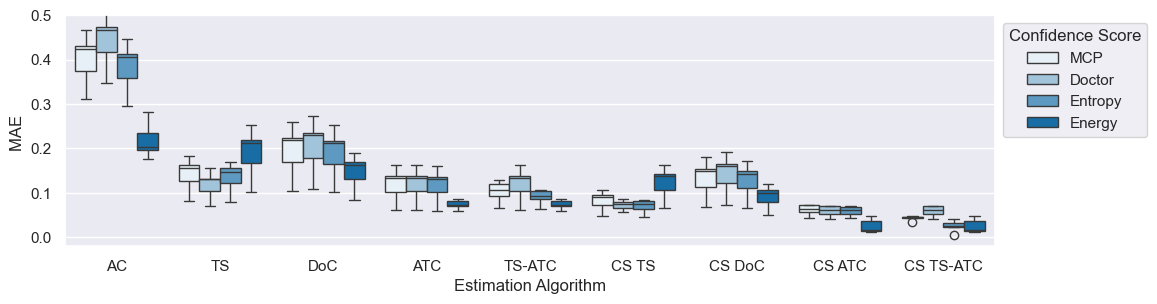

In [25]:
sns.set(rc={'figure.figsize':(12,3)})
category_palette = {'MCP': '#e5f0f8',
                    'Doctor': '#99c6e4',
                    'Entropy': '#4c9cd0',
                    'Energy': '#0072bd'
                   }
ax = sns.boxplot(df, x="Estimation Algorithm", y="MAE ", hue="Confidence Score", palette=category_palette)
ax.set(ylim=(-0.02, 0.5))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))